In [5]:
import gzip
import numpy as np
import pickle
from scipy.sparse import csr_array
import os
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import os
import re
import random
import matplotlib
from matplotlib import colors
import copy

np.set_printoptions(suppress=True)

In [6]:
top = 'aes_cipher_top'

In [7]:
dset = f'../DREAMPlace/install/dataset/{top}/{top}_0.7_1.0.icc2.pklz'
# dset = '../DREAMPlace/install/dataset/bsg_chip/bsg_chip_0.7_1.25.gp.pklz'
with gzip.open(dset) as f:
    dataset = pickle.load(f)

pin2net = np.array(dataset['pin_info']['pin2net_map'])
pin2node = np.array(dataset['pin_info']['pin2node_map'])

In [8]:
# hypergraph incidence matrix
H = csr_array((np.ones(len(pin2net)), (pin2node, pin2net)))

flat_net2pin_map = np.array(dataset['net_info']['flat_net2pin_map'])
flat_net2pin_start_map = np.array(dataset['net_info']['flat_net2pin_start_map'])
flat_node2pin_map =  np.array(dataset['node_info']['flat_node2pin_map'])
flat_node2pin_start_map =  np.array(dataset['node_info']['flat_node2pin_start_map'])

my_net2pin_map = np.array([flat_net2pin_map[flat_net2pin_start_map[i]:flat_net2pin_start_map[i+1]] \
                                for i in range(len(flat_net2pin_start_map) - 1)], dtype=object)

po_x = np.array(dataset['pin_info']['pin_offset'])[0]
po_y = np.array(dataset['pin_info']['pin_offset'])[1]
pos_x = np.array(dataset['node_info']['node_position'])[0]
pos_y = np.array(dataset['node_info']['node_position'])[1]

my_net2pin_map = np.array([flat_net2pin_map[flat_net2pin_start_map[i]:flat_net2pin_start_map[i+1]] \
                            for i in range(len(flat_net2pin_start_map) - 1)], dtype=object)
my_node2pin_map = np.array([flat_node2pin_map[flat_node2pin_start_map[i]:flat_node2pin_start_map[i+1]] \
                            for i in range(len(flat_node2pin_start_map) - 1)], dtype=object)

net2node = [[] for _ in range(H.shape[1])]
for pin, net in enumerate(pin2net):
    net2node[net].append(str(pin2node[pin] + 1))
    
hpwl_collection = []
for n in range(len(my_net2pin_map)):
    pins = my_net2pin_map[n]
    pin_offset = np.vstack([po_x[pins], po_y[pins]]).T
    pos = np.vstack([pos_x[pin2node[pins]], pos_y[pin2node[pins]]]).T

    pin_pos = pos + pin_offset

    amax = np.max(pin_pos, axis=0)
    amin = np.min(pin_pos, axis=0)

    hpwl_collection.append((amax - amin).sum())
hpwl_collection = np.array(hpwl_collection)

In [9]:
pindir = dataset['pin_info']['pin_direct']
pindir[0]

b'INPUT'

In [10]:
H.shape[1]

10588

(10588, 15)
10588
105


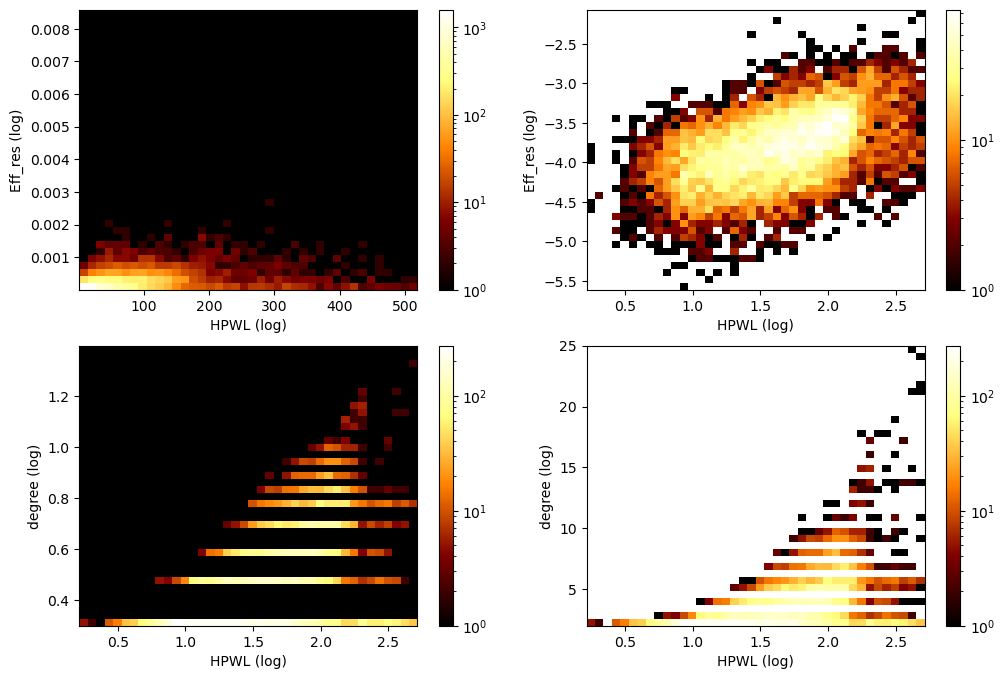

In [11]:
# load eratio
eratio = np.load(f'HyperEF_julia/src/tmp/{top}_py.npy')

# Approx. eff. res.
evec = np.sort(eratio, axis=1)[:,::-1]
print(evec.shape)
print(len(hpwl_collection))
P = evec[:,0]

# Only 1% nets
total_net_num = len(hpwl_collection)
cut_off_num = int(total_net_num * 10 / 1000)
print(cut_off_num)

# cut large nets
hpwl_max_idx = np.argsort(hpwl_collection)[::-1][:cut_off_num]
hpwl_ = np.delete(hpwl_collection, hpwl_max_idx)
P = np.delete(P, hpwl_max_idx)
net2node_ = np.delete(np.array(net2node, dtype=object), hpwl_max_idx)

# hpwl_min_idx = np.argsort(hpwl_collection)[:cut_off_num]
# hpwl_ = np.delete(hpwl_collection, hpwl_min_idx)
# eff_res_ = np.delete(P, hpwl_min_idx)
# net2node_ = np.delete(np.array(net2node, dtype=object), hpwl_min_idx)

# hpwl_ = hpwl_collection
# eff_res_ = P
# net2node_ = np.array(net2node, dtype=object)

## GRID LABEL
# num_class = 20
# heatmap_grid = np.zeros((num_class, num_class))
# hpwl_class = np.zeros(len(hpwl_collection), dtype=int)
# eff_class = np.zeros(len(hpwl_collection), dtype=int)

# net_to_class = np.array_split(np.argsort(hpwl_collection), num_class)
# for label in range(num_class):
#     hpwl_class[net_to_class[label]] = label

# eff_to_class = np.array_split(np.argsort(P), num_class)
# for label in range(num_class):
#     eff_class[eff_to_class[label]] = label

# df = pd.DataFrame()

# df['hpwl'] = hpwl_class
# df['eff_res'] = eff_class

# for index, row in df.iterrows():
#     heatmap_grid[row['hpwl'], row['eff_res']] += 1

# ignore singleton net
zero_idx = np.argwhere(hpwl_ == 0).flatten()
hpwl_ = np.delete(hpwl_, zero_idx)
evec_ = np.delete(P, zero_idx)
degree_ = np.delete(np.array([len(x) for x in net2node_]), zero_idx)

evec_[evec_ < 10e-10] = 10e-10

fig = plt.figure(figsize=(12,8))
fig.set_facecolor('white')
my_cmap = copy.copy(matplotlib.colormaps['afmhot']) # copy the default cmap
my_cmap.set_bad((0,0,0))

ax1 = fig.add_subplot(221)
h = ax1.hist2d(hpwl_, evec_, bins=40, norm=colors.LogNorm(), cmap=my_cmap)
ax1.set_xlabel('HPWL (log)')
ax1.set_ylabel('Eff_res (log)')
cur_ax = plt.gca() ## 현재 Axes
fig.colorbar(h[3],ax=cur_ax) ## 컬러바 추가

ax2 = fig.add_subplot(222)
h = ax2.hist2d(np.log10(hpwl_), np.log10(evec_), bins=40, norm=colors.LogNorm(), cmap=matplotlib.colormaps['afmhot'])
ax2.set_xlabel('HPWL (log)')
ax2.set_ylabel('Eff_res (log)')
cur_ax = plt.gca() ## 현재 Axes
fig.colorbar(h[3],ax=cur_ax) ## 컬러바 추가

ax3 = fig.add_subplot(223)
h  = ax3.hist2d(np.log10(hpwl_), np.log10(degree_), bins=40, norm=colors.LogNorm(), cmap=my_cmap)
ax3.set_xlabel('HPWL (log)')
ax3.set_ylabel('degree (log)')
cur_ax = plt.gca() ## 현재 Axes
fig.colorbar(h[3],ax=cur_ax) ## 컬러바 추가

ax4 = fig.add_subplot(224)
h = ax4.hist2d(np.log10(hpwl_), degree_, bins=40, norm=colors.LogNorm(), cmap=matplotlib.colormaps['afmhot'])
ax4.set_xlabel('HPWL (log)')
ax4.set_ylabel('degree (log)')
cur_ax = plt.gca() ## 현재 Axes
fig.colorbar(h[3],ax=cur_ax) ## 컬러바 추가

fig.savefig('xxx')


In [12]:
df = pd.DataFrame()
df['hpwl'] = np.log10(hpwl_)
df['degree'] = np.log10(degree_)
df['eff_res'] = np.log10(evec_)

df.corr()

,hpwl,degree,eff_res
hpwl,1.000000,0.481760,0.485975
degree,0.481760,1.000000,0.626777
eff_res,0.485975,0.626777,1.000000
